Aim of this paper is to predict values for some of India's stan, so I will combine features' values form each city to get mean features' value for that stan. Thanks to this approch I will be able to reduce number of rows therefore time reduction for training machine learning algoritms and most importantlly I will reduce number of missing values. 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer, SimpleImputer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style("darkgrid")
# Set the random seed for reproducibility
np.random.seed(0)

$\textbf{Data Import}$

In [11]:
df = pd.read_csv('../Data_for_Imputation/Dataframe_Andhra_Pradesh.csv', index_col= 'datetime')
df.index = pd.to_datetime(df.index)
col_to_impute = df.columns.to_list()
col_to_impute.remove('city')
df.head(2)

,PM10 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),Temp (degree C),RH (%),WS (m/s),SR (W/mt2),BP (mmHg),VWS (m/s),Xylene (ug/m3),RF (mm),AT (degree C),city,WD (degree)
datetime,,,,,,,,,,,,,,,,,,,
2016-07-01 10:00:00,39.0,32.33,7.07,6.6,0.48,14.5,1.0,4.63,33.43,71.67,2.3,123.67,NaN,-0.1,0.1,0.0,23.05,Tirupati,226.33
2016-07-01 11:00:00,39.0,35.80,7.40,NaN,0.49,15.0,0.7,4.50,33.70,70.00,2.5,186.00,NaN,-0.1,0.1,0.0,NaN,Tirupati,223.00


For visualization of imputation I will use Temp (degree C) feature

In [12]:
def imputation_result_plot(df_imputed: pd.DataFrame, df: pd.DataFrame, title: str):
    """
    Plot the comparison between imputed data and original data for a specific feature and city.

    Parameters:
    df_imputed (pd.DataFrame): DataFrame containing imputed data.
    df (pd.DataFrame): Original DataFrame containing data before imputation.
    title (str): Title for the plot.

    Returns:
    None
    """
    
    # Define feature, city, and date for comparison
    feature = 'Temp (degree C)'
    city = 'Tirupati'
    date = '2018-06'
    
    # Filter indexes for the specified date
    indexes = df.index.strftime('%Y-%m') == date

    # Select data for comparison from both imputed and original DataFrames
    df_imputed_to_compare = df_imputed[indexes]
    df_imputed_to_compare = df_imputed_to_compare[df_imputed_to_compare['city'] == city][feature]

    df_to_compare = df[indexes]
    df_to_compare = df_to_compare[df_to_compare['city'] == city][feature]

    # Create a new figure for the plot
    plt.figure(figsize=(15, 8))

    # Plot the main line with markers for original data
    df_to_compare.plot(style='-', title=f'{feature} - {title}', label= 'imported dataframe')

    # Add points where data was imputed with red color
    plt.scatter(
        x=df_to_compare[df_to_compare.isna()].index,
        y=df_imputed_to_compare[df_to_compare.isna()],
        label = 'imputed values',
        color='red',
        marker='.'
    )

    # Set labels for x-axis, y-axis, and title
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend()

    # Display the plot
    plt.show()

$\textbf{Data Imputation}$

Last Observation Carried Forward and Backward

In [24]:
# Create a copy of the original dataframe to perform imputations
df_imputed = df.copy()

# Get a list of unique cities in the dataframe
cities = df['city'].unique()

# Loop through each city to perform forward fill imputation
for city in cities:
    # Apply forward and backward fill imputation for the specified column within each city
    df_imputed.loc[df_imputed['city'] == city, col_to_impute] = df.loc[df_imputed['city'] == city, col_to_impute].fillna(method="ffill").fillna(method='bfill')

# Resample the dataframe to have mean values for each 60-minute interval
df_to_save = df_imputed.resample('60min').mean(numeric_only=True)

# Display the first 3 rows of the resampled dataframe
df_to_save.head(3)

# Save the resampled dataframe to a CSV file with the specified path and include the index
df_to_save.to_csv('../Data_for_ML/LOCFnB_Andhra_Pradesh.csv', index=True)


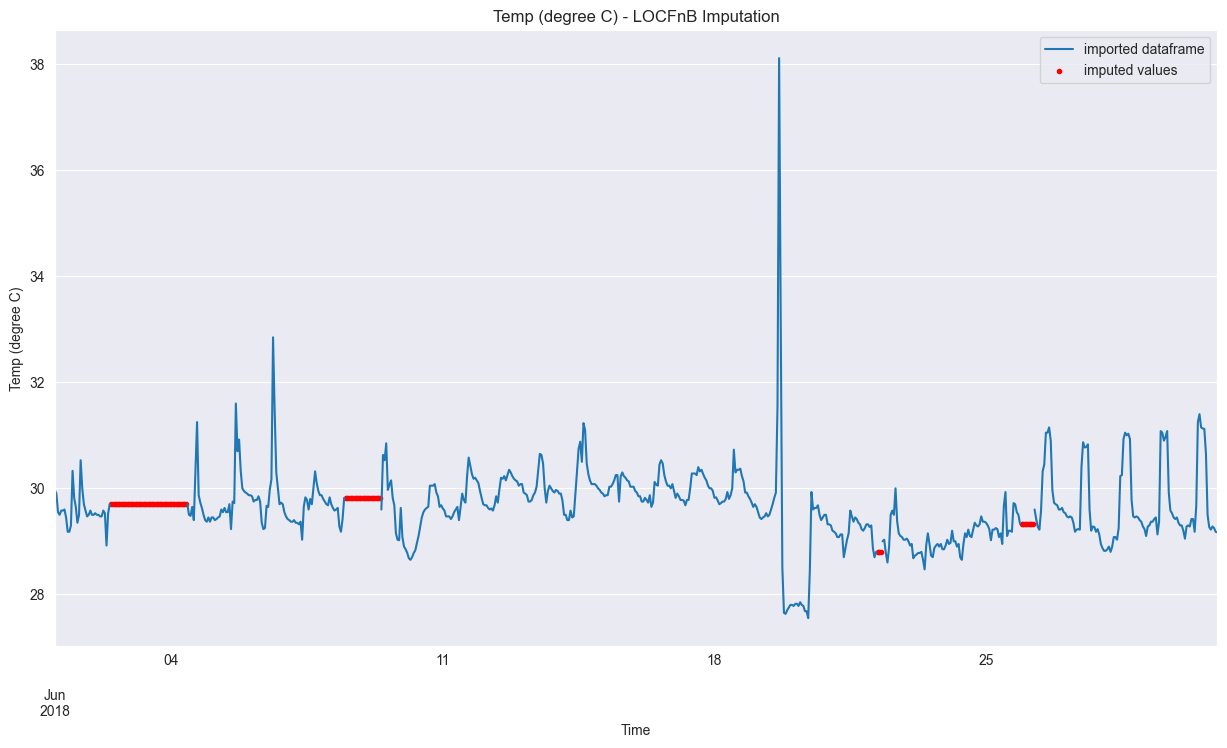

In [25]:
title = 'LOCFnB Imputation'
imputation_result_plot(df_imputed= df_imputed, df= df, title= title)

kNN imputer

In [15]:
# Create a copy of the original dataframe to perform imputations
df_imputed = df.copy()

# Initialize the KNN Imputer with 3 nearest neighbors
imp = KNNImputer(n_neighbors=3)

# Select the columns that need to be imputed
filtered_data = df[col_to_impute]

# Apply KNN imputation to the selected columns and assign the imputed values back to the dataframe
df_imputed[col_to_impute] = imp.fit_transform(filtered_data)

# Resample the dataframe to have mean values for each 60-minute interval
df_to_save = df_imputed.resample('60min').mean(numeric_only=True)

# Display the first 3 rows of the resampled dataframe
df_to_save.head(3)

# Save the resampled dataframe to a CSV file with the specified path and include the index
df_to_save.to_csv('../Data_for_ML/kNN_Andhra_Pradesh.csv', index=True)


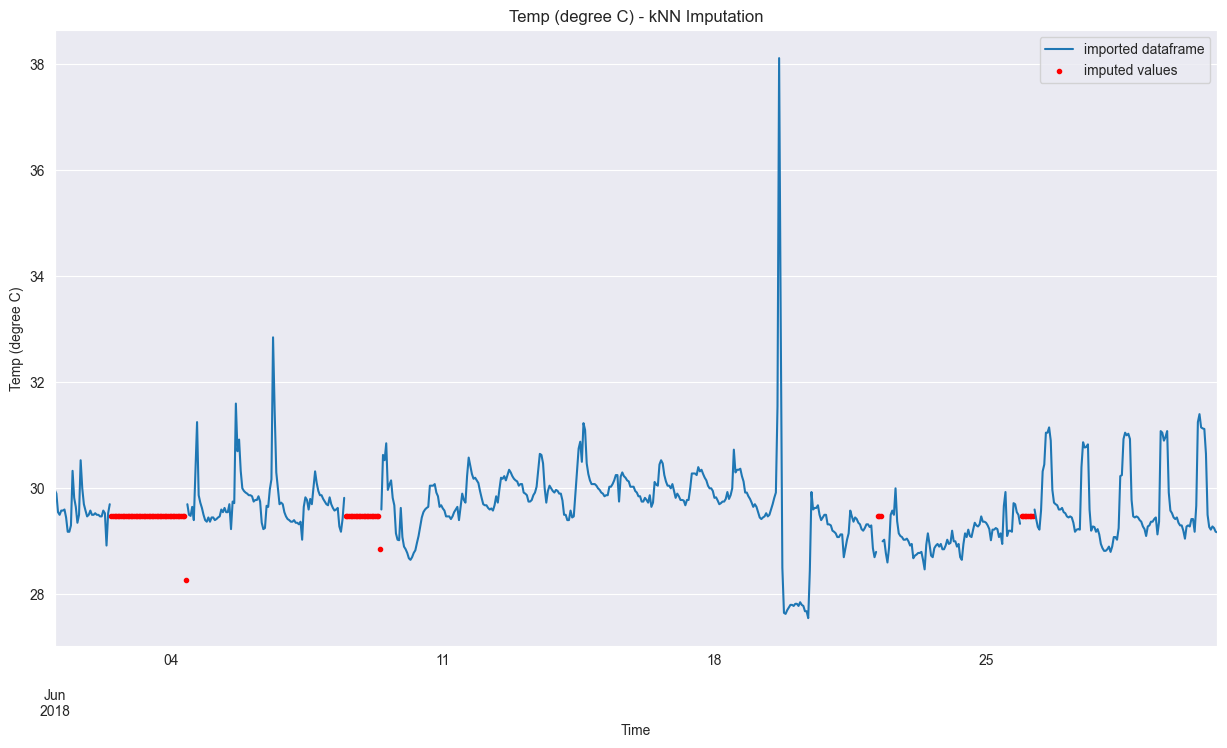

In [16]:
title = 'kNN Imputation'
imputation_result_plot(df_imputed= df_imputed, df= df, title= title)

Mean - Imputation

In [17]:
# Create a copy of the original dataframe to perform imputations
df_imputed = df.copy()

# Get a list of unique cities in the dataframe
cities = df['city'].unique()

# Loop through each city to perform mean imputation
for city in cities:
    # Initialize the SimpleImputer with mean strategy for the current city
    imp = SimpleImputer(strategy="mean")
    
    # Select the rows and columns to impute for the current city
    filtered_data = df.loc[df_imputed['city'] == city, col_to_impute]
    
    try:
        # Apply mean imputation to the selected data and update the dataframe
        df_imputed.loc[df_imputed['city'] == city, col_to_impute] = imp.fit_transform(filtered_data)
    except:
        # Pass in case of any exception (e.g., if there's nothing to impute for a city)
        pass

# Initialize the SimpleImputer with mean strategy for the entire dataframe
imp = SimpleImputer(strategy="mean")

# Apply mean imputation to the entire dataframe for the specified columns
df_imputed[col_to_impute] = imp.fit_transform(df_imputed[col_to_impute])

# Resample the dataframe to have mean values for each 60-minute interval
df_to_save = df_imputed.resample('60min').mean(numeric_only=True)

# Display the first 3 rows of the resampled dataframe
df_to_save.head(3)

# Save the resampled dataframe to a CSV file with the specified path and include the index
df_to_save.to_csv('../Data_for_ML/Mean_Andhra_Pradesh.csv', index=True)


a:\Python\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Temp (degree C)' 'Xylene (ug/m3)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
a:\Python\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Temp (degree C)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
a:\Python\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Temp (degree C)' 'Xylene (ug/m3)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
a:\Python\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Temp (degree C)' 'Xylene (ug/m3)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


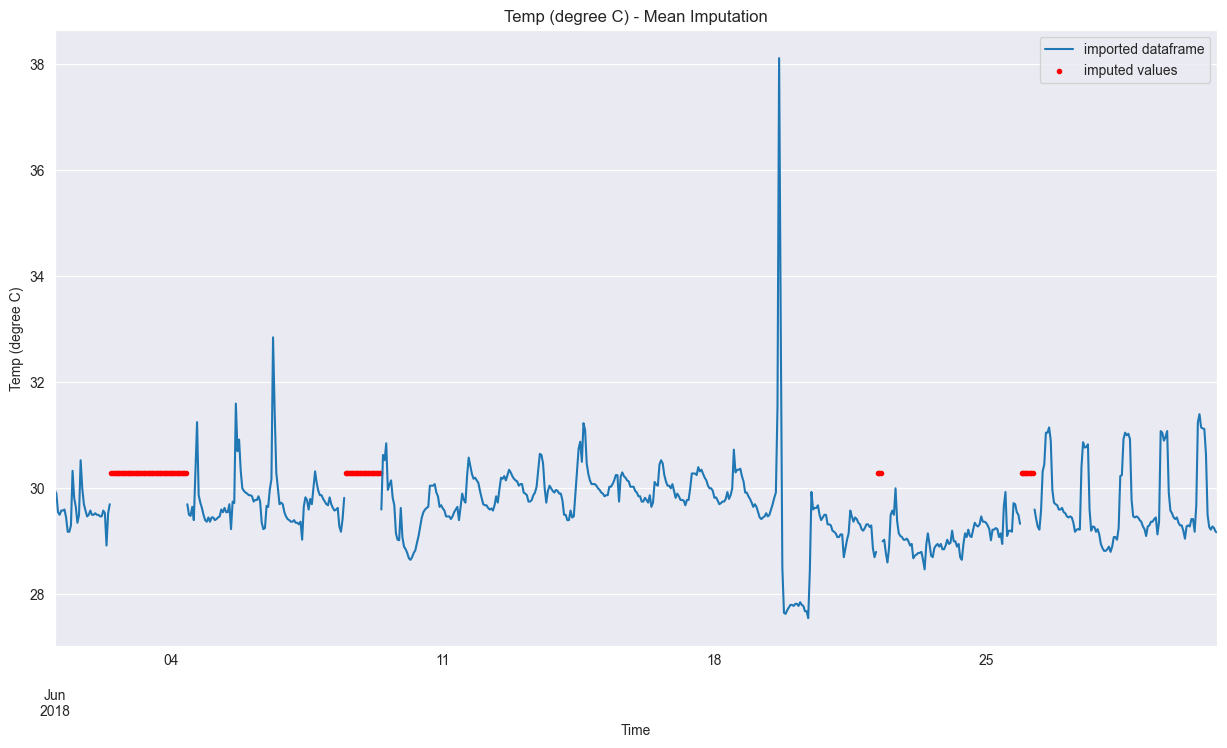

In [18]:
title = 'Mean Imputation'
imputation_result_plot(df_imputed= df_imputed, df= df, title= title)

Linear Interpolation - Imputer

In [23]:
# Create a copy of the original dataframe to perform interpolations
df_imputed = df.copy()

# Get a list of unique cities in the dataframe
cities = df['city'].unique()

# Apply linear interpolation method for each city and specified columns
for city in cities:
    for col in col_to_impute:
        # Select the data for the current city and column
        filtered_data = df_imputed.loc[df_imputed['city'] == city, col]

        # Apply linear interpolation to the selected data
        df_imputed.loc[df_imputed['city'] == city, col] = filtered_data.interpolate(method="linear")

        # Fill any remaining missing values with the mean of the column
        df_imputed.loc[df_imputed['city'] == city, col] = filtered_data.fillna(filtered_data.mean())

# Resample the dataframe to have mean values for each 60-minute interval
df_to_save = df_imputed.resample('60min').mean(numeric_only=True)

# Display the first 3 rows of the resampled dataframe
df_to_save.head(3)

# Save the resampled dataframe to a CSV file with the specified path and include the index
df_to_save.to_csv('../Data_for_ML/Linear_interpolation_Andhra_Pradesh.csv', index=True)

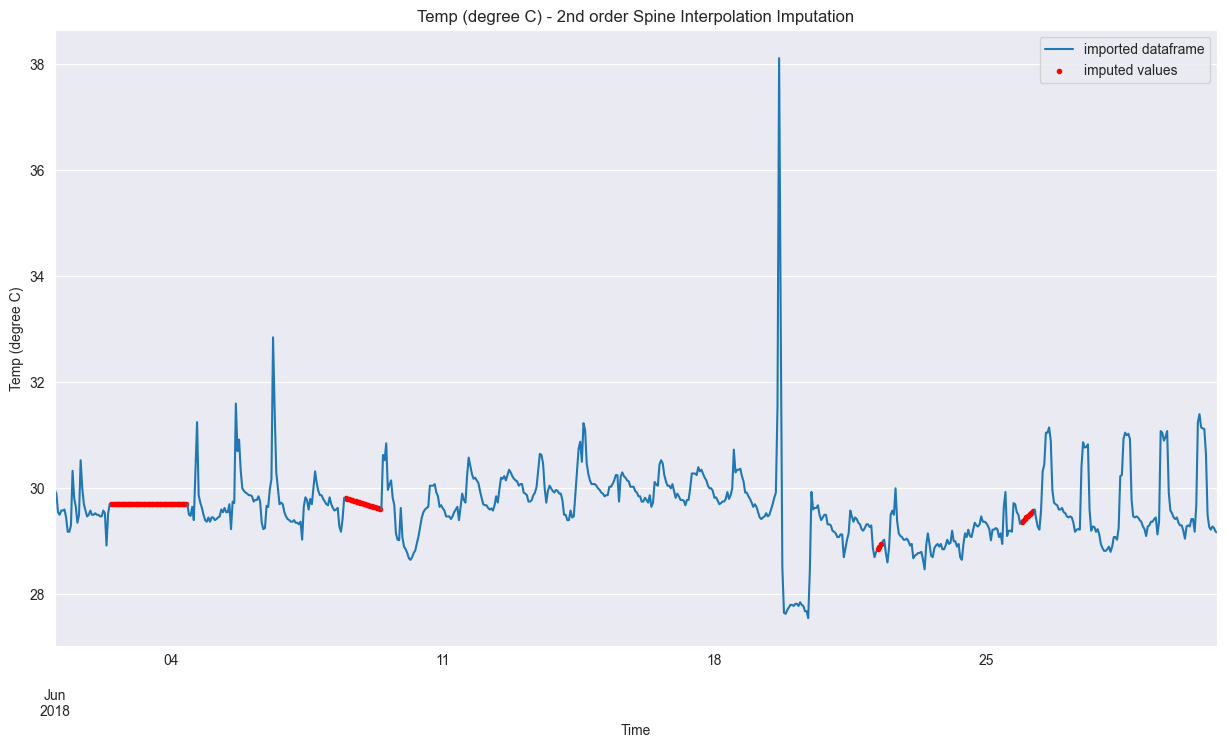

In [ ]:
title = 'Linear Interpolation Imputation'
imputation_result_plot(df_imputed= df_imputed, df= df, title= title)